Imports

In [10]:
# Copyright (c) Microsoft. All rights reserved.

# Licensed under the MIT license. See LICENSE.md file in the project root
# for full license information.
# ==============================================================================

import argparse
import numpy as np
import sys
import os
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(tf.test.is_built_with_cuda())
print (tf.config.list_physical_devices('GPU') )

print (tf.test.is_gpu_available())

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


OS Utils

In [ ]:
# #abs_path = os.path.dirname(os.path.abspath(__file__))

# def check_path(path):
#     if not os.path.exists(path):
#         readme_file = os.path.normpath(os.path.join(
#             os.path.dirname(path), "..", "README.md"))
#         raise RuntimeError(
#             "File '%s' does not exist. Please follow the instructions at %s to download and prepare it." % (path, readme_file))

Setup Input Data

Deserializer expects the format `sequenceId <tab> path <tab> label`



In [6]:
# def dataset_label(index, path):
# 	foldername = os.path.basename(os.path.dirname(path))
# 	return str(index).zfill(5) + "\t" + os.path.normpath(path) + "\t" + os.path.normpath(foldername)

We just need to parse through the folders and build our labels.
It's easy because we can just base it on directory name

For each folder in the data directory, find all files with the type `.png`, `jpg`, `jpeg`, `.gif`

concat the output of dataset_label into an array

In [4]:
DATA_DIR = os.path.normpath("\\\\NAS12139F\\Business\\Collections\\")

In [3]:


# # For each folder in the data directory, find all files with the type `.png`, `jpg`, `jpeg`, `.gif`
# # concat the output of dataset_label into an array, then save to file

# def label_builder():

# 	label_filename = os.path.dirname(DATA_DIR) + ".txt"
# 	print ("Looking for label file: " + label_filename)
# 	# if file exists, return it's path
# 	if os.path.isfile(label_filename):
# 		print ("Found label file: " + label_filename)
# 		return os.path.join(label_filename)

# 	print ("Creating label file")
# 	label_array = []
# 	class_track = []
# 	index = 0
# 	# directory tree traversal
# 	for root, dirs, files in os.walk(DATA_DIR):
# 		for file in files:
# 			if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".gif"):
# 				label_array.append(dataset_label(index, os.path.join(root, file)))
# 				class_track.append(os.path.normpath(os.path.basename(os.path.dirname(os.path.join(root, file)))))
# 				index += 1
# 	# save labels to file
# 	with open(label_filename, "w") as f:
# 		for label in label_array:
# 			if len(label) != len(label.encode()):
# 				continue
# 			f.write(label)
# 			f.write("\n")
# 	print ("Label file saved to: " + label_filename)
# 	NUM_CLASSES = len(np.unique(class_track))
# 	print("Number of classes: " + str(NUM_CLASSES))

# 	#return path to file
# 	return label_filename

# Generate Labels

# label_builder()

Generate a dataset

(Using Keras now)

In [5]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  	layers.RandomFlip("horizontal_and_vertical"),
  	layers.RandomRotation(0.2),
  	layers.RandomZoom(0.1),
])


In [34]:
seed_in = 5421
image_size = (256, 256)

train_ds = keras.preprocessing.image_dataset_from_directory(
	DATA_DIR,
	validation_split=0.2,
	subset="training",
	seed=seed_in,
	image_size=image_size,
	batch_size=BATCH_SIZE,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
	DATA_DIR,
	validation_split=0.2,
	subset="validation",
	seed=seed_in,
	image_size=image_size,
	batch_size=BATCH_SIZE,
)

class_track = train_ds.class_names

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

train_ds.cache()



Found 1338 files belonging to 10 classes.
Using 1071 files for training.
Found 1338 files belonging to 10 classes.
Using 267 files for validation.


<CacheDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
print("Number of classes: " + str(len(class_track)))

print("Classes: " + str(class_track))

Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

    We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
    We include a Dropout layer before the final classification layer.

https://keras.io/examples/vision/image_classification_from_scratch/


# Training Funcs

In [18]:
def trainModel(model, name, epochs=20):

   callbacks = [
      #keras.callbacks.ModelCheckpoint("models/augment_{epoch}.h5"),
      keras.callbacks.ModelCheckpoint("models/"+ name +"_best.h5", save_best_only=True, monitor="val_accuracy"),
   ]
   return model.fit(
      train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
   )


# Model Classes



In [13]:
def swish(x):
	return x * tf.nn.sigmoid(x)

In [17]:
# augment dataset
inputs = keras.Input(shape=image_size + (3,))
aug_model = data_augmentation(inputs)

In [18]:
if aug_model is None:
	print("No augmentation")
	model = keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3),padding="same", activation=swish, input_shape=image_size + (3,)))
model.add(keras.layers.Conv2D(32, (3, 3), padding="same", activation=swish))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation=swish))
model.add(keras.layers.Conv2D(64, (3, 3), padding="same", activation=swish))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), activation=swish))
model.add(keras.layers.Conv2D(128, (3, 3), activation=swish))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=swish))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(class_track), activation='softmax'))

model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
)

#model.build(input_shape=image_size + (3,))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)       

In [ ]:
# Train model
trainModel(model, "augment", epochs=20):

# load example model
model = keras.models.load_model("models/resenet50_trans_pooled_best.h5")

## Transfer Learning from ResNet50

In [23]:
# Transfer learning model
base_model = keras.models.Sequential()

pretrained_model = keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=image_size + (3,),
)

# Freeze base model
pretrained_model.trainable = False

base_model.add(pretrained_model)

base_model.add(keras.layers.Flatten())
base_model.add(keras.layers.Dense(512, activation=swish))
base_model.add(keras.layers.Dense(len(class_track), activation='softmax'))



In [24]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


This is our base model

The ResNet50 portion is frozen, and we just train the top.

In [30]:
# load example model
base_model = keras.models.load_model("models/resenet50_trans_pooled_best.h5")

Epoch 1/20
34/34 [==============================] - 38s 855ms/step - loss: 0.5998 - accuracy: 0.8263 - val_loss: 0.2776 - val_accuracy: 0.9251
Epoch 2/20
34/34 [==============================] - 33s 809ms/step - loss: 0.1963 - accuracy: 0.9514 - val_loss: 0.3238 - val_accuracy: 0.8801
Epoch 3/20
34/34 [==============================] - 33s 816ms/step - loss: 0.1407 - accuracy: 0.9748 - val_loss: 0.3073 - val_accuracy: 0.8951
Epoch 4/20
34/34 [==============================] - 32s 787ms/step - loss: 0.1035 - accuracy: 0.9841 - val_loss: 0.3152 - val_accuracy: 0.8989
Epoch 5/20
34/34 [==============================] - 32s 790ms/step - loss: 0.0698 - accuracy: 0.9925 - val_loss: 0.4119 - val_accuracy: 0.8502
Epoch 6/20
34/34 [==============================] - 32s 789ms/step - loss: 0.0590 - accuracy: 0.9907 - val_loss: 0.3732 - val_accuracy: 0.8689
Epoch 7/20
34/34 [==============================] - 33s 806ms/step - loss: 0.0532 - accuracy: 0.9935 - val_loss: 0.4783 - val_accuracy: 0.8427

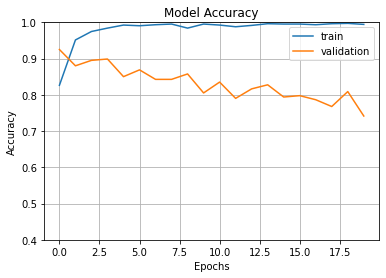

In [31]:
base_model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
)

history = trainModel(base_model, "resenet50_trans_pooled", 20)

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Once we're getting good accuracy (converged on the new data), we unfreeze the model and train the whole thing.

Important that we use a low learning rate so we don't make big jumps and overwrite things

In [ ]:
base_model.summary()

In [32]:
#Load the model
model = keras.models.load_model("models/resenet50_trans_pooled_v2.h5")

In [35]:
model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
)

trainModel(model, "resenet50_transfer_ete", 20)

Epoch 1/20
34/34 [==============================] - 46s 906ms/step - loss: 0.9596 - accuracy: 0.6611 - val_loss: 0.3016 - val_accuracy: 0.9064
Epoch 2/20
34/34 [==============================] - 34s 821ms/step - loss: 0.4668 - accuracy: 0.8739 - val_loss: 0.4238 - val_accuracy: 0.8764
Epoch 3/20
34/34 [==============================] - 34s 820ms/step - loss: 0.2782 - accuracy: 0.9505 - val_loss: 0.5086 - val_accuracy: 0.8464
Epoch 4/20
34/34 [==============================] - 34s 840ms/step - loss: 0.1766 - accuracy: 0.9851 - val_loss: 0.5762 - val_accuracy: 0.7790
Epoch 5/20
34/34 [==============================] - 33s 825ms/step - loss: 0.1218 - accuracy: 0.9897 - val_loss: 0.6435 - val_accuracy: 0.7753
Epoch 6/20
34/34 [==============================] - 33s 813ms/step - loss: 0.0884 - accuracy: 0.9907 - val_loss: 0.6952 - val_accuracy: 0.7640
Epoch 7/20
34/34 [==============================] - 34s 838ms/step - loss: 0.0663 - accuracy: 0.9944 - val_loss: 0.7278 - val_accuracy: 0.7528

# Prediction Area

In [ ]:
# load a model

# load an image

def print_image(model, img):
	img_array = keras.preprocessing.image.img_to_array(img)
	img_array = tf.expand_dims(img_array, 0)  # Create batch axis

	predictions = model.predict(img_array)
	for i in np.argpartition(predictions[0], -3)[-3:]:
		print(class_track[i] + ": " + str(predictions[0][i]))
	print("---")


images = [
	"images/2pvptp6z5ul81.jpg",
	"images/3o3mq3j5q1j81.jpg",
	"images/35w8x7t3tz761.png",
	"images/BeWN228.png",
	"images/carj0fmcxei81.png",
	"images/wyn90upnrwm81.jpg",
	"images/yvxknmz03di81.jpg",
]


#Load the model
model = keras.models.load_model("models/resenet50_trans_pooled_v2.h5")

for img_path in images:
	img = keras.preprocessing.image.load_img(
		img_path, target_size=image_size
	)
	print (img_path)
	print_image(model, img)
